# Install library

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

from tensorflow.keras.layers import Input, Dense, Conv2D, Activation
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

## Dataset preprocessing and EDA

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data() # load data
x_train,x_test = x_train.astype('float32')/255.0,x_test.astype('float32')/255.0 # normalization
# x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
# x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [3]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [4]:
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

In [5]:
# No method on keras to get cifar10 category label name by categoly label?
cifar10_labels = np.array([
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'])

bird_ind = np.where(cifar10_labels=='bird')
deer_ind = np.where(cifar10_labels=='deer')
truck_ind = np.where(cifar10_labels=='truck')

In [6]:
remove_num = 2500
counter = 0
train_num = len(y_train) - remove_num * 3 # for 3 classes
x_train_removed =  np.zeros(x_train.shape)[:train_num]
y_train_removed =  np.zeros(y_train.shape)[:train_num]

# bird, deer, truck labeld data is removed by 2500
bird_limit, deer_limit, truck_limit = 0, 0, 0
for i, label in enumerate(y_train):
    if (label != bird_ind) & (label != deer_ind) & (label != truck_ind):
        x_train_removed[counter] = x_train[i]
        y_train_removed[counter] = y_train[i]
        counter += 1
    else:
        if label == bird_ind:
            if bird_limit < 2500:
                bird_limit += 1
                x_train_removed[counter] = x_train[i]
                y_train_removed[counter] = y_train[i]
                counter += 1
                continue
            else: continue
        if label == deer_ind:
            if deer_limit < 2500:
                deer_limit += 1
                x_train_removed[counter] = x_train[i]
                y_train_removed[counter] = y_train[i]
                counter += 1
                continue
            else: continue
        if label == truck_ind:
            if truck_limit < 2500:
                truck_limit += 1
                x_train_removed[counter] = x_train[i]
                y_train_removed[counter] = y_train[i]
                counter += 1
                continue
            else: continue

y_train_removed = np.array(y_train_removed, dtype='uint8')

In [7]:
print(x_train_removed.shape)
print(y_train_removed.shape)
del x_train
del y_train

(42500, 32, 32, 3)
(42500, 1)


In [8]:
df = pd.DataFrame(y_train_removed.flatten())
print(df.value_counts())
del df

0    5000
1    5000
3    5000
5    5000
6    5000
7    5000
8    5000
2    2500
4    2500
9    2500
dtype: int64


(array([5000., 5000., 2500., 5000., 2500., 5000., 5000., 5000., 5000.,
        2500.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

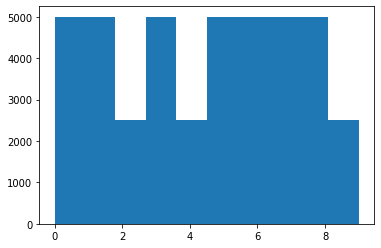

In [9]:
import matplotlib.pyplot as plt

# データ数をプロット
plt.hist(y_train_removed.flatten())

## AutoEncoder

In [10]:
# For autoencode ver2
# encoding_dim = 32  # 32 dimention
# input_img = Input(shape=(3072,), name="Input_AE") # 32 * 32 * 3
# encoded = Dense(encoding_dim, activation='relu', name="Dense_AE_0")(input_img)
# decoded = Dense(3072, activation='sigmoid', name="Dense_AE_1")(encoded) # 32 * 32 * 3
# autoencoder = Model(input_img, decoded)

# 中間層を 4 層まで増やしたネットワーク
# autoencoder = models.Sequential()
# autoencoder.add()
# autoencoder.add(layers.Dense(128, activation='relu',
#                        input_shape=(3072,), name="Dense_AE_0"))
# autoencoder.add(layers.Dense(64, activation='relu', name="Dense_AE_1"))
# autoencoder.add(layers.Dense(encoding_dim, activation='relu', name="Dense_AE_2"))
# autoencoder.add(layers.Dense(64, activation='relu', name="Dense_AE_3"))
# autoencoder.add(layers.Dense(128, activation='relu', name="Dense_AE_4"))
# autoencoder.add(layers.Dense(3072,
#                        activation='sigmoid', name="Dense_AE_5"))

In [11]:
# def create_bench_model():
#     inputs = Input(shape = (32,32,3))
#     x = Conv2D(64,(3,3),padding = "SAME",activation= "relu")(inputs)
#     x = Conv2D(64,(3,3),padding = "SAME",activation= "relu")(x)
#     x = Dropout(0.25)(x)
#     x = MaxPooling2D()(x)

#     x = Conv2D(128,(3,3),padding = "SAME",activation= "relu")(x)
#     x = Conv2D(128,(3,3),padding = "SAME",activation= "relu")(x)
#     x = Dropout(0.25)(x)
#     x = MaxPooling2D()(x)

#     x = Conv2D(256,(3,3),padding = "SAME",activation= "relu")(x)
#     x = Conv2D(256,(3,3),padding = "SAM　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　E",activation= "relu")(x)
#     x = GlobalAveragePooling2D()(x)

#     x = Dense(1024,activation = "relu")(x)
#     x = Dropout(0.25)(x)
#     y = Dense(10,activation = "softmax")(x)

#     return Model(inputs, y)

# model = create_bench_model()
# model.summary()

In [10]:
class AE01():
    def __init__(self):
        input_img = Input(shape=(32, 32, 3))  # 0
        conv1 = Conv2D(64, (3, 3), activation='relu', padding='same', name="Dense_AE01_1")(input_img)  # 1

#         encoded = conv1
        
        decoded = Conv2D(3, (3, 3), activation='relu', padding='same', name="Dense_AE01_2")(conv1)  # 2

        self.encoder = None
        self.autoencoder = Model(input_img, decoded)

    def compile(self, optimizer='adam', loss='binary_crossentropy'):
        adam = Adam(lr=0.001, decay=0.005)
        self.autoencoder.compile(optimizer=adam, loss=loss)

    def train(self, x_train=None, x_test=None, epochs=1, batch_size=32, shuffle=True):
        es_cb = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
        chkpt = '../models/AE/stack01_autoencoder_best.hdf5'
        cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
       
        self.autoencoder.fit(x_train, x_train,
                             epochs=epochs,
                             batch_size=batch_size,
                             shuffle=shuffle,
                             callbacks=[es_cb, cp_cb],
                             validation_data=(x_test, x_test))
        
        self.autoencoder.load_weights(chkpt)
        
        self.encoder = Model(self.autoencoder.input, self.autoencoder.layers[1].output)
        encode_model_path = '../models/AE/stack01_encoder_best.hdf5'
        self.encoder.save(encode_model_path)

In [11]:
ae01_epochs = 1
ae01_batch_size = 32
ae1 = AE01()
ae1.compile()
ae1.train(x_train_removed, x_test, ae01_epochs, ae01_batch_size)

1328/1329 [============================>.] - ETA: 0s - loss: 0.5550
Epoch 00001: val_loss improved from inf to 0.54979, saving model to ../models/AE\stack01_autoencoder_best.hdf5
1329/1329 [==============================] - 37s 28ms/step - loss: 0.5550 - val_loss: 0.5498


In [20]:
class AE02():
    def __init__(self):
        input_img = Input(shape=(32, 32, 64))  # 0
        conv1 = Conv2D(128, (3, 3), activation='relu', padding='same', name="Conv_AE02_1")(input_img)  # 1
        pool1 = MaxPooling2D(name="Pool_AE02_1")(conv1)  # 2

#         encoded = pool1
        
        unpool1 = UpSampling2D(name="Unpool_AE02_1")(pool1)  # 3
        decoded = Conv2D(64, (3, 3), activation='relu', padding='same', name="Conv_AE02_2")(unpool1)  # 4

        self.encoder = None
        self.autoencoder = Model(input_img, decoded)

    def compile(self, optimizer='adam', loss='binary_crossentropy'):
        adam = Adam(lr=0.001, decay=0.005)
        self.autoencoder.compile(optimizer=adam, loss=loss)

    def train(self, x_train=None, x_test=None, epochs=1, batch_size=32, shuffle=True):
        es_cb = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
        chkpt = '../models/AE/stack02_autoencoder_best.hdf5'
        cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
       
        self.autoencoder.fit(x_train, x_train,
                             epochs=epochs,
                             batch_size=batch_size,
                             shuffle=shuffle,
                             callbacks=[es_cb, cp_cb],
                             validation_data=(x_test, x_test))
        
        self.autoencoder.load_weights(chkpt)
        
        self.encoder = Model(self.autoencoder.input, self.autoencoder.layers[1].output)
        encode_model_path = '../models/AE/stack02_encoder_best.hdf5'
        self.encoder.save(encode_model_path)

In [21]:
class AE03():
    def __init__(self):
        input_img = Input(shape=(16, 16, 128))  # 0
        conv1 = Conv2D(256, (3, 3), activation='relu', padding='same', name="Conv_AE03_1")(input_img)  # 1
        pool1 = MaxPooling2D(name="Pool_AE03_1")(conv1)  # 2

        encoded = pool1
        
        unpool1 = UpSampling2D(name="Unpool_AE03_1")(pool1)  # 3
        decoded = Conv2D(128, (3, 3), activation='relu', padding='same', name="Conv_AE03_2")(unpool1)  # 4

        self.encoder = None
        self.autoencoder = Model(input_img, decoded)

    def compile(self, optimizer='adam', loss='binary_crossentropy'):
        adam = Adam(lr=0.001, decay=0.005)
        self.autoencoder.compile(optimizer=adam, loss=loss)

    def train(self, x_train=None, x_test=None, epochs=1, batch_size=32, shuffle=True):
        es_cb = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
        chkpt = '../models/AE/stack03_autoencoder_best.hdf5'
        cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
       
        self.autoencoder.fit(x_train, x_train,
                             epochs=epochs,
                             batch_size=batch_size,
                             shuffle=shuffle,
                             callbacks=[es_cb, cp_cb],
                             validation_data=(x_test, x_test))
        
        self.autoencoder.load_weights(chkpt)
        
        self.encoder = Model(self.autoencoder.input, self.autoencoder.layers[1].output)
        encode_model_path = '../models/AE/stack03_encoder_best.hdf5'
        self.encoder.save(encode_model_path)

In [22]:
ae02_epochs = 1
ae02_batch_size = 32
ae2 = AE02()
ae2.compile()

encoded_train1 = ae1.encoder.predict(x_train_removed)
encoded_test1 = ae1.encoder.predict(x_test)
ae2.train(encoded_train1, encoded_test1, ae02_epochs, ae02_batch_size)

1328/1329 [============================>.] - ETA: 0s - loss: 0.2683
Epoch 00001: val_loss improved from inf to 0.26308, saving model to ../models/AE\stack02_autoencoder_best.hdf5
1329/1329 [==============================] - 147s 110ms/step - loss: 0.2683 - val_loss: 0.2631


In [39]:
ae2.autoencoder.summary()
ae2.autoencoder.layers

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 64)]      0         
_________________________________________________________________
Dense_AE02_1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 32, 32, 128)       0         
_________________________________________________________________
Dense_AE02_2 (Conv2D)        (None, 32, 32, 64)        73792     
Total params: 147,648
Trainable params: 147,648
Non-trainable params: 0
_________________________________________________________________


In [46]:
class StackedAE01:
    def __init__(self):
        input_img = Input(shape=(32, 32, 3))  # 0
        conv1 = Conv2D(64, (3, 3), activation='relu', padding='same', name="Conv_StackedAE01_1")(input_img)  # 1
        conv2 = Conv2D(128, (3, 3), activation='relu', padding='same', name="Conv_StackedAE01_2")(conv1)  # 2
        pool1 = MaxPooling2D(name="Pool_StackedAE01_1")(conv2)  # 3
        unpool1 = UpSampling2D(name="Unpool_StackedAE01_1")(pool1)  # 4
        deconv1 = Conv2D(64, (3, 3), activation='relu', padding='same', name="Conv_StackedAE01_3")(unpool1)  # 5
        decoded = Conv2D(3, (3, 3), activation='relu', padding='same', name="Conv_StackedAE01_4")(deconv1)  # 6
        
        self.encoder = None
        self.autoencoder = Model(input_img, decoded)
        
    def compile(self, optimizer='adam', loss='binary_crossentropy'):
        adam = Adam(lr=0.001, decay=0.005)
        self.autoencoder.compile(optimizer=adam, loss=loss)
        
    def train(self, x_train=None, x_test=None, epochs=1, batch_size=32, shuffle=True):
        es_cb = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
        chkpt = '../models/AE/full_autoencoder_best.hdf5'
        cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
       
        self.autoencoder.fit(x_train, x_train,
                             epochs=epochs,
                             batch_size=batch_size,
                             shuffle=shuffle,
                             callbacks=[es_cb, cp_cb],
                             validation_data=(x_test, x_test))
        
        self.autoencoder.load_weights(chkpt)
        
        self.encoder = Model(self.autoencoder.input, self.autoencoder.get_layer('Pool_StackedAE01_1').output)
        encode_model_path = '../models/AE/full_encoder_best.hdf5'
        self.encoder.save(encode_model_path)
    
    def load_weights(self, ae01, ae02):
        self.autoencoder.layers[1].set_weights(ae01.layers[1].get_weights())
        self.autoencoder.layers[2].set_weights(ae02.layers[1].get_weights())
        
        self.autoencoder.layers[5].set_weights(ae02.layers[4].get_weights())
        self.autoencoder.layers[6].set_weights(ae01.layers[2].get_weights())

stacked01_epochs = 1
stacked01_batch_size = 32

stack_ae1 = StackedAE01()
stack_ae1.load_weights(ae1.autoencoder, ae2.autoencoder)
stack_ae1.compile()
stack_ae1.train(x_train_removed, x_test, stacked01_epochs, stacked01_batch_size)

1328/1329 [============================>.] - ETA: 0s - loss: 0.5551
Epoch 00001: val_loss improved from inf to 0.55162, saving model to ../models/AE\full_autoencoder_best.hdf5
1329/1329 [==============================] - 151s 113ms/step - loss: 0.5551 - val_loss: 0.5516


In [ ]:
# model.summary()
class CNN01:
    def __init__(self, encoder):
        
        input_img = encoder.input
        output = encoder.layers[-1].output # 16,16,128
        x = Dropout(0.25)(output)
        x = MaxPooling2D()(x)

        x = Conv2D(256,(3,3),padding = "SAME",activation= "relu")(x)
        x = Conv2D(256,(3,3),padding = "SAME",activation= "relu")(x)
        x = GlobalAveragePooling2D()(x)

        x = Dense(1024,activation = "relu")(x)
        x = Dropout(0.25)(x)
        y = Dense(10,activation = "softmax")(x)
        
        self.model = Model(input_img, y)
        
    def compile(self, optimizer='adam', loss='binary_crossentropy'):
        adam = Adam(lr=0.001, decay=0.005)
        self.model.compile(loss = "categorical_crossentropy",optimizer = adam, metrics = ["accuracy"])
        
    def train(self, x_train=None, y_train=None, x_test=None, y_test=None ,epochs=1, batch_size=32, shuffle=True):
        es_cb = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
        chkpt = '../models/CNN/model_best_01.hdf5'
        cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
       
        self.model.fit(x_train, y_train,
                             epochs=epochs,
                             batch_size=batch_size,
                             shuffle=shuffle,
                             callbacks=[es_cb, cp_cb],
                             validation_data=(x_test, y_test))
        
        self.model.load_weights(chkpt)

from tensorflow.keras.utils import plot_model, to_categorical

# one hot encoding
nb_classes = 10
y_train_removed_onehot = to_categorical(y_train_removed, nb_classes)
y_test_onehot = to_categorical(y_test, nb_classes)        

epochs = 20
batch_size = 32
cnn1 = CNN01(stack_ae1.encoder)
cnn1.compile()
cnn1.train(x_train_removed, y_train_removed_onehot, x_test, y_test_onehot, epochs, batch_size)
# x_train_removed.shape

Epoch 1/20
 484/1329 [=========>....................] - ETA: 59s - loss: 1.8172 - accuracy: 0.3182

In [18]:
ae03_epochs = 1
ae03_batch_size = 32
ae3 = AE03()
ae3.compile()

encoded_train2 = ae2.encoder.predict(encoded_train1)
encoded_test2 = ae2.encoder.predict(encoded_test1)

ValueError: in user code:

    C:\Users\koki inoue\anaconda3\envs\tf2.3\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Users\koki inoue\anaconda3\envs\tf2.3\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\koki inoue\anaconda3\envs\tf2.3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\koki inoue\anaconda3\envs\tf2.3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\koki inoue\anaconda3\envs\tf2.3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\koki inoue\anaconda3\envs\tf2.3\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Users\koki inoue\anaconda3\envs\tf2.3\lib\site-packages\tensorflow\python\keras\engine\training.py:747 train_step
        y_pred = self(x, training=True)
    C:\Users\koki inoue\anaconda3\envs\tf2.3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\koki inoue\anaconda3\envs\tf2.3\lib\site-packages\tensorflow\python\keras\engine\functional.py:385 call
        return self._run_internal_graph(
    C:\Users\koki inoue\anaconda3\envs\tf2.3\lib\site-packages\tensorflow\python\keras\engine\functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    C:\Users\koki inoue\anaconda3\envs\tf2.3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    C:\Users\koki inoue\anaconda3\envs\tf2.3\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:212 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer Dense_AE03_2 is incompatible with the layer: expected axis -1 of input shape to have value 128 but received input with shape [None, 32, 32, 64]


In [66]:
x_train_removed.shape

(42500, 32, 32, 3)

In [13]:
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_AE (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
Dense_AE_0 (Dense)           (None, 32)                98336     
_________________________________________________________________
Dense_AE_1 (Dense)           (None, 3072)              101376    
Total params: 199,712
Trainable params: 199,712
Non-trainable params: 0
_________________________________________________________________


In [14]:
# # hyperparameters
# batch_size = 32
# epochs = 50

# # train
# saveDir = "../models/AE/"

# autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# es_cb = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
# # chkpt = saveDir + 'AE_Cifar10.{epoch:02d}-{loss:.2f}-{val_loss:.2f}.hdf5'
# chkpt = saveDir + 'AE_Cifar10_002_Best.hdf5'
# cp_cb = ModelCheckpoint(filepath = chkpt, \
#        monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

# AE_history = autoencoder.fit(x_train_removed, x_train_removed,
#                     batch_size=batch_size,
#                     epochs=epochs,
#                     verbose=1,
#                     validation_data=(x_test, x_test),
#                     callbacks=[es_cb, cp_cb],
#                     shuffle=True)

Text(0.5, 0, 'epoch')

<Figure size 432x288 with 0 Axes>

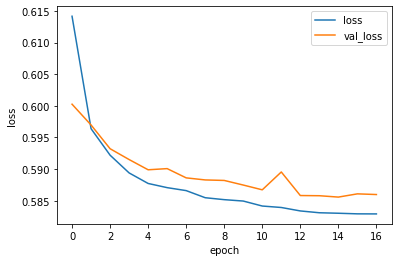

In [33]:
# # plot training
# AE_hist_df = pd.DataFrame(AE_history.history)

# plt.figure()
# AE_hist_df[['loss', 'val_loss']].plot()
# plt.ylabel('loss')
# plt.xlabel('epoch')

In [16]:
autoencoder.load_weights("../models/AE/AE_Cifar10_001_Best.hdf5")
# autoencoder.trainable = False
# For encode
# layer_name_0 = 'Dense_AE_0'
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('Dense_AE_1').output)

In [17]:
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_AE (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
Dense_AE_0 (Dense)           (None, 32)                98336     
_________________________________________________________________
Dense_AE_1 (Dense)           (None, 3072)              101376    
Total params: 199,712
Trainable params: 199,712
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Encode and decode some digits
decoded_imgs = autoencoder.predict(x_test)

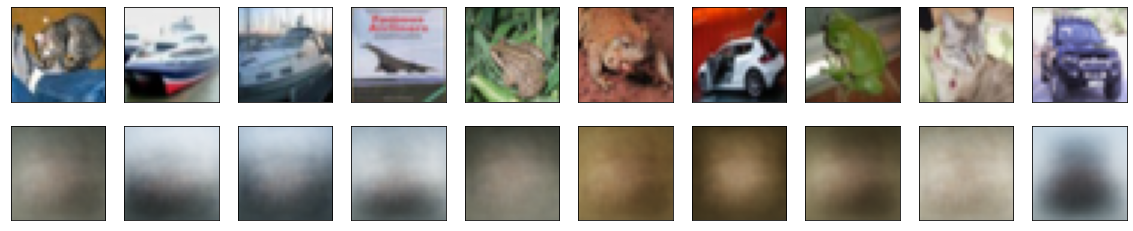

In [19]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Classification Model

In [37]:
autoencoder.trainable = False

In [38]:
encoder.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_AE_0_input (InputLayer [(None, 3072)]            0         
_________________________________________________________________
Dense_AE_0 (Dense)           (None, 128)               393344    
_________________________________________________________________
Dense_AE_1 (Dense)           (None, 64)                8256      
_________________________________________________________________
Dense_AE_2 (Dense)           (None, 32)                2080      
Total params: 403,680
Trainable params: 0
Non-trainable params: 403,680
_________________________________________________________________


In [39]:
model = Sequential()

model.add(encoder)
model.add(Dense(10, activation='softmax',name="Dense_0",input_shape=(32,)))
# model.add(BatchNormalization())
# model.add(Activation('softmax'))
adam = Adam(lr=1e-4)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=["accuracy"])

In [40]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_5 (Functional)    (None, 32)                403680    
_________________________________________________________________
Dense_0 (Dense)              (None, 10)                330       
Total params: 404,010
Trainable params: 330
Non-trainable params: 403,680
_________________________________________________________________


In [41]:
from tensorflow.keras.utils import plot_model, to_categorical

# one hot encoding
nb_classes = 10
y_train_removed_onehot = to_categorical(y_train_removed, nb_classes)
y_test_onehot = to_categorical(y_test, nb_classes)

# train
saveDir = "../models/CNN/"

es_cb = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
# chkpt = saveDir + 'Affine_Cifar10.{epoch:02d}-{loss:.2f}-{val_loss:.2f}.hdf5'
chkpt = saveDir + 'Affine_Cifar10_002_Best.hdf5'
cp_cb = ModelCheckpoint(filepath = chkpt, \
       monitor='val_loss', verbose=1, save_best_only=True, mode='auto')


Affine_history = model.fit(x_train_removed, y_train_removed_onehot,
                    batch_size=32,
                    epochs=400,
                    verbose=1,
                    validation_data=(x_test, y_test_onehot),
                    callbacks=[es_cb, cp_cb],
                    shuffle=True)

Epoch 1/400
1282/1329 [===========================>..] - ETA: 0s - loss: 3.5714 - accuracy: 0.1023
Epoch 00001: val_loss improved from inf to 2.84471, saving model to ../models/CNN\Affine_Cifar10_002_Best.hdf5
1329/1329 [==============================] - 1s 944us/step - loss: 3.5455 - accuracy: 0.1025 - val_loss: 2.8447 - val_accuracy: 0.1051
Epoch 2/400
1291/1329 [============================>.] - ETA: 0s - loss: 2.7282 - accuracy: 0.1227 ETA: 0s - loss: 2.7542 - ac
Epoch 00002: val_loss improved from 2.84471 to 2.70684, saving model to ../models/CNN\Affine_Cifar10_002_Best.hdf5
1329/1329 [==============================] - 1s 883us/step - loss: 2.7261 - accuracy: 0.1234 - val_loss: 2.7068 - val_accuracy: 0.1194
Epoch 3/400
1274/1329 [===========================>..] - ETA: 0s - loss: 2.5867 - accuracy: 0.1369
Epoch 00003: val_loss improved from 2.70684 to 2.57681, saving model to ../models/CNN\Affine_Cifar10_002_Best.hdf5
1329/1329 [==============================] - 1s 883us/step - los

## Result

Text(0.5, 0, 'epoch')

<Figure size 432x288 with 0 Axes>

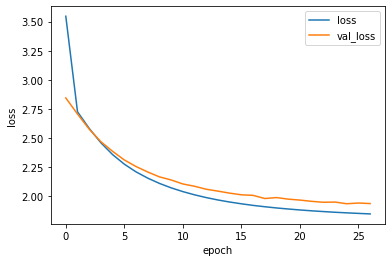

<Figure size 432x288 with 0 Axes>

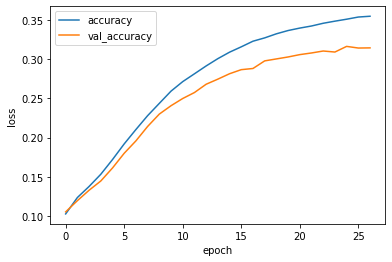

In [42]:
# plot training
Affine_hist_df = pd.DataFrame(Affine_history.history)

plt.figure()
Affine_hist_df[['loss', 'val_loss']].plot()
plt.ylabel('loss')
plt.xlabel('epoch')

plt.figure()
Affine_hist_df[['accuracy', 'val_accuracy']].plot()
plt.ylabel('loss')
plt.xlabel('epoch')

In [43]:
# load best model
model.load_weights("../models/CNN/Affine_Cifar10_002_Best.hdf5")

In [44]:
model.evaluate(x_test , y_test_onehot)

313/313 [==============================] - 0s 655us/step - loss: 1.9374 - accuracy: 0.3163


[1.937394380569458, 0.31630000472068787]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Confusion matrix, without normalization


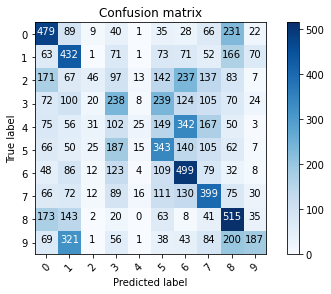

In [45]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


predict_classes = model.predict_classes(x_test)
true_classes = y_test
confusion_mtx = confusion_matrix(true_classes, predict_classes) 
plot_confusion_matrix(confusion_mtx, classes = range(10)) 